`cd project/seniorthesis/notebooks`

`conda list PyCO2SYS`

`pip install PyCO2SYS`

`pip install git+https://github.com/jbusecke/cmip6_preprocessing.git`

`mv *.png ../figures`

This code does polar stereographic projections for `gr` models. Time is averaged over the first 20 years (i.e. January 1850 to December 1869).

Images are saved as `source_id.gr.historical.Omon_variable_id_depth_stereoproj_20yr.png`

Here is the template for how I coding the visualization

```
for name, ds in dd.items():

    a = ds.variable.isel(lev = 1)

    surf = a.isel(time = slice(0, 239)).mean('time', keep_attrs=True)

    lat = surf.lat.transpose('y','x')

    lon = surf.lon.transpose('y','x')
    
    draw_SOcustom(lon.data,lat.values,surf,cmap='viridis',cbar_label='Variable (units)',
                  title=name+' at depth',plot_type='pcolormesh',clims=[0,1])
                  
    plt.savefig(name+'variable_depth_stereoproj_20yr.png')
```

In [1]:
import xarray as xr
from cmip6_preprocessing.preprocessing import combined_preprocessing
import PyCO2SYS as pyco2 # i have to install this package through terminal for it to work
import intake
import matplotlib.pyplot as plt
import numpy as np
import warnings
import gsw
from cmip6_preprocessing.postprocessing import combine_datasets
from cartopy import crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import cmocean
import matplotlib.path as mpath
from cmip6_preprocessing.postprocessing import combine_datasets
from cmip6_preprocessing.postprocessing import merge_variables

In [2]:
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")

#### Here are all my functions

In [3]:
def draw_SOcustom(X,Y,Z,cmap,cbar_label,title,plot_type,**kwargs):
    
    crs_plot = ccrs.SouthPolarStereo()
    crs_source = ccrs.PlateCarree()
    
    fig,ax = plt.subplots(figsize=(10,10),subplot_kw={'projection':crs_plot})
    ax.add_feature(cfeature.LAND,zorder=10,facecolor='darkgray')
    ax.set_extent([-180, 180, -90, -30], crs_source)
    # Compute a circle in axes coordinates, which we can use as a boundary
    # for the map. We can pan/zoom as much as we like - the boundary will be
    # permanently circular.
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    
    ax.gridlines()
    ax.coastlines()
    
    ax.set_title(title,fontsize=14,pad = 20)
    
    if plot_type == 'contourf':
        im = ax.contourf(X,Y,Z,kwargs['clevs'],cmap=cmap,transform=crs_source)
    elif plot_type == 'pcolormesh':
        im = ax.pcolormesh(X,Y,Z,cmap=cmap,transform=crs_source,vmin=kwargs['clims'][0],vmax=kwargs['clims'][1])
    
    cbar = plt.colorbar(im,orientation='horizontal',fraction=0.025,pad=0.05)
    cbar.set_label(cbar_label,fontsize=12)
    
#     plt.show()
    
    return fig,ax

def pick_first_member(ds_list, **kwargs):
    return ds_list[0]

def calc_PpCO2(ds):
    p = gsw.p_from_z(-1*ds['lev'], ds['y'], geo_strf_dyn_height=0, sea_surface_geopotential=0)
    insitutemp = gsw.t_from_CT(ds['so'], ds['thetao'], p)  # 0 is just a filler rn 
    results = pyco2.sys(par1=ds['talk']*1035.0,par2=ds['dissic']*1035.0,par1_type=1,par2_type=2,
                        pressure_out=0, temperature_out = ds['thetao'], pressure = p, 
                        temperature = insitutemp)
    return ds['talk'].copy(data=results['pCO2_out'])

def meridionalsection(ax,da,clims=None,title=None):
    im = ax.pcolormesh(da['y'],da['lev'],da)
    if clims is not None:
        im.set_clim(clims)
    ax.set_xlim([-80,60])
    ax.invert_yaxis()
    plt.colorbar(im,ax=ax)
    ax.set_title(title)
    
def calc_sigma2(ds):
    return gsw.sigma2(ds['so'],ds['thetao'])

def meridionalsection_with_sigma2(ax,da,sigma2,clims=None,title=None):
    meridionalsection(ax,da,clims)
    ax.contour(da['y'],da['lev'],sigma2,levels=[36,36.4,36.8],colors='w')
    ax.set_title(title)

### `dissic`, `talk`, `so`, and `thetao`

In [4]:
variables = ['dissic','talk', 'so', 'thetao']
z_kwargs = {'consolidated': True, 'use_cftime': True}
query = dict(experiment_id=['historical'], 
             table_id=['Omon'], 
             variable_id=variables,
             grid_label=['gr'],
              source_id=['GFDL-ESM4', 'CESM2-WACCM', 'CESM2', 
                         'CESM2-FV2', 'NorESM2-LM', 'MRI-ESM2-0', 
                         'GFDL-CM4', 'CESM2-WACCM-FV2']
            )


cat = col.search(**query)

# print(cat.df['source_id'].unique())
dset_dict_old = cat.to_dataset_dict(zarr_kwargs=z_kwargs, storage_options={'token': 'anon'},
                                preprocess=combined_preprocessing, aggregate=False)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


In [5]:
dd_new = merge_variables(dset_dict_old)
list(dd_new.keys())

/srv/conda/envs/notebook/lib/python3.8/site-packages/cmip6_preprocessing/postprocessing.py:122: UserWarning: CMIP.NCAR.CESM2-FV2.historical.r3i1p1f1.Omon.gr.none failed to combine with :indexes along dimension 'time' are not equal
  warnings.warn(f"{cmip6_dataset_id(ds)} failed to combine with :{e}")
/srv/conda/envs/notebook/lib/python3.8/site-packages/cmip6_preprocessing/postprocessing.py:122: UserWarning: CMIP.NCAR.CESM2-FV2.historical.r2i1p1f1.Omon.gr.none failed to combine with :indexes along dimension 'time' are not equal
  warnings.warn(f"{cmip6_dataset_id(ds)} failed to combine with :{e}")
/srv/conda/envs/notebook/lib/python3.8/site-packages/cmip6_preprocessing/postprocessing.py:122: UserWarning: CMIP.NCAR.CESM2-WACCM-FV2.historical.r2i1p1f1.Omon.gr.none failed to combine with :indexes along dimension 'time' are not equal
  warnings.warn(f"{cmip6_dataset_id(ds)} failed to combine with :{e}")
/srv/conda/envs/notebook/lib/python3.8/site-packages/cmip6_preprocessing/postprocessing.

['GFDL-CM4.gr.historical.Omon.r1i1p1f1',
 'CESM2.gr.historical.Omon.r3i1p1f1',
 'CESM2.gr.historical.Omon.r11i1p1f1',
 'MRI-ESM2-0.gr.historical.Omon.r4i1p1f1',
 'CESM2.gr.historical.Omon.r1i1p1f1',
 'CESM2-WACCM.gr.historical.Omon.r2i1p1f1',
 'CESM2.gr.historical.Omon.r9i1p1f1',
 'CESM2.gr.historical.Omon.r5i1p1f1',
 'GFDL-ESM4.gr.historical.Omon.r1i1p1f1',
 'NorESM2-LM.gr.historical.Omon.r2i1p1f1',
 'CESM2-WACCM-FV2.gr.historical.Omon.r1i1p1f1',
 'CESM2-WACCM.gr.historical.Omon.r1i1p1f1',
 'CESM2-WACCM.gr.historical.Omon.r3i1p1f1',
 'MRI-ESM2-0.gr.historical.Omon.r2i1p1f1',
 'NorESM2-LM.gr.historical.Omon.r3i1p1f1',
 'MRI-ESM2-0.gr.historical.Omon.r1i2p1f1',
 'CESM2.gr.historical.Omon.r8i1p1f1',
 'CESM2-FV2.gr.historical.Omon.r1i1p1f1',
 'CESM2.gr.historical.Omon.r4i1p1f1',
 'MRI-ESM2-0.gr.historical.Omon.r3i1p1f1',
 'NorESM2-LM.gr.historical.Omon.r1i1p1f1',
 'MRI-ESM2-0.gr.historical.Omon.r5i1p1f1',
 'CESM2.gr.historical.Omon.r7i1p1f1',
 'CESM2.gr.historical.Omon.r2i1p1f1',
 'MRI-ES

### Filter for models with all vars: `dissic`, `talk`, `so`, and `thetao`

In [6]:
dd_has_all_vars={}
for name,item in dd_new.items():
    #print(name)
    #print(item.data_vars)
    present = item.data_vars
    if all(i in present for i in variables):
        #print(name)
        dd_has_all_vars[name]=item
list(dd_has_all_vars.keys())

['GFDL-CM4.gr.historical.Omon.r1i1p1f1',
 'CESM2.gr.historical.Omon.r3i1p1f1',
 'CESM2.gr.historical.Omon.r11i1p1f1',
 'CESM2.gr.historical.Omon.r1i1p1f1',
 'CESM2-WACCM.gr.historical.Omon.r2i1p1f1',
 'CESM2.gr.historical.Omon.r9i1p1f1',
 'CESM2.gr.historical.Omon.r5i1p1f1',
 'GFDL-ESM4.gr.historical.Omon.r1i1p1f1',
 'CESM2-WACCM-FV2.gr.historical.Omon.r1i1p1f1',
 'CESM2-WACCM.gr.historical.Omon.r1i1p1f1',
 'CESM2-WACCM.gr.historical.Omon.r3i1p1f1',
 'MRI-ESM2-0.gr.historical.Omon.r1i2p1f1',
 'CESM2.gr.historical.Omon.r8i1p1f1',
 'CESM2-FV2.gr.historical.Omon.r1i1p1f1',
 'CESM2.gr.historical.Omon.r4i1p1f1',
 'NorESM2-LM.gr.historical.Omon.r1i1p1f1',
 'CESM2.gr.historical.Omon.r7i1p1f1',
 'CESM2.gr.historical.Omon.r2i1p1f1',
 'CESM2.gr.historical.Omon.r6i1p1f1']

### Combine datasets and pick first member

In [7]:
dd_new_new = combine_datasets(
    dd_has_all_vars,
    pick_first_member,
    match_attrs=['source_id', 'grid_label', 'experiment_id', 'table_id']
)
list(dd_new_new.keys())

['GFDL-CM4.gr.historical.Omon',
 'CESM2.gr.historical.Omon',
 'CESM2-WACCM.gr.historical.Omon',
 'GFDL-ESM4.gr.historical.Omon',
 'CESM2-WACCM-FV2.gr.historical.Omon',
 'MRI-ESM2-0.gr.historical.Omon',
 'CESM2-FV2.gr.historical.Omon',
 'NorESM2-LM.gr.historical.Omon']

In [8]:
dd_so={}
dd_DIC={}
dd_talk={}
dd_thetao={}

for name,item in dd_new_new.items():
    #print(name)
    #print(item.data_vars)
    #present = item.data_vars
    SO = 'so'
    THETAO = 'thetao'
    TALK = 'talk'
    DIC = 'dissic'
    FGCO2 = 'fgco2'
    #if all(i in present for i in variables):
        #print(name)
        #temp[name]=dset_dict[name]
    if SO in item:
        dd_so[name] = item
    if DIC in item:
        dd_DIC[name] = item
    if TALK in item:
        dd_talk[name] = item
    if THETAO in item:
        dd_thetao[name] = item


# Dissolved Inorganic Carbon

#### 0m

/srv/conda/envs/notebook/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1702: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


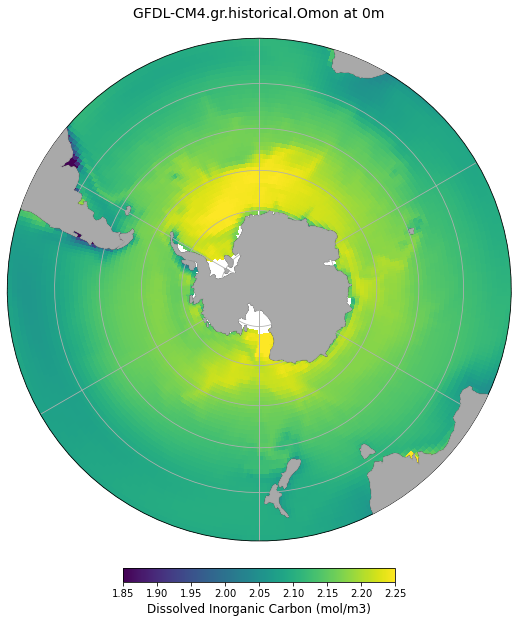

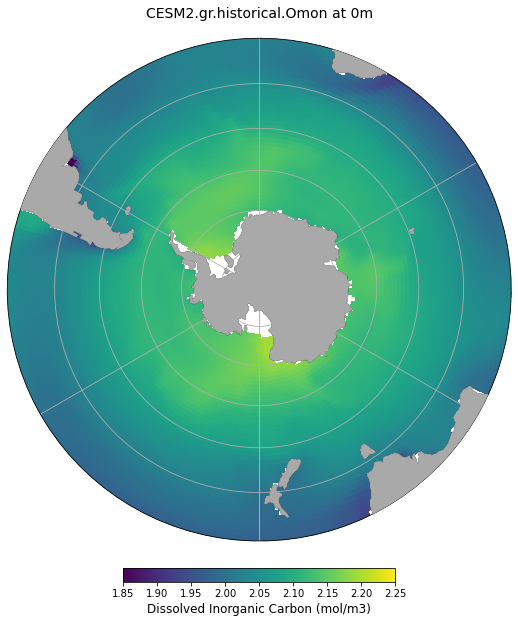

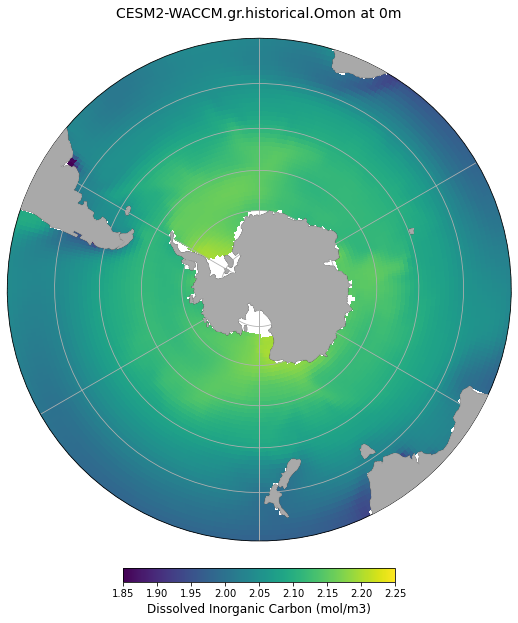

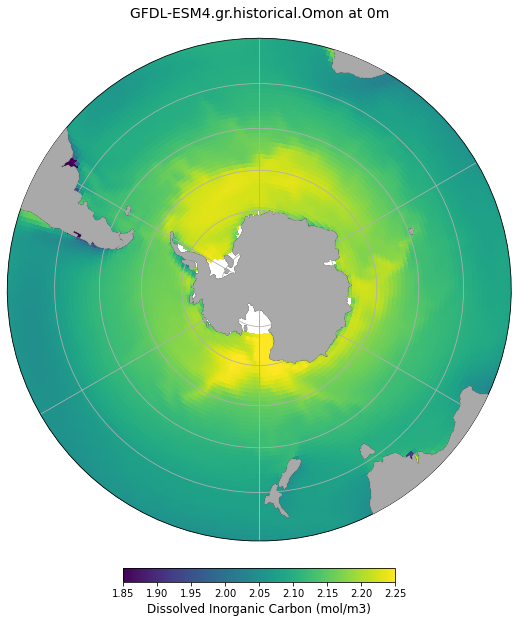

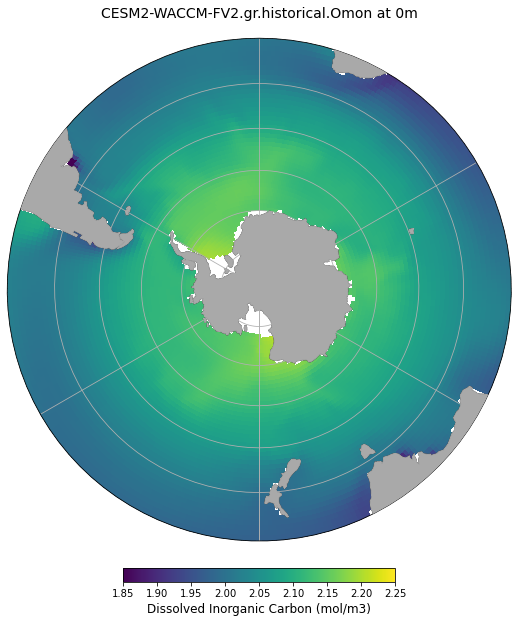

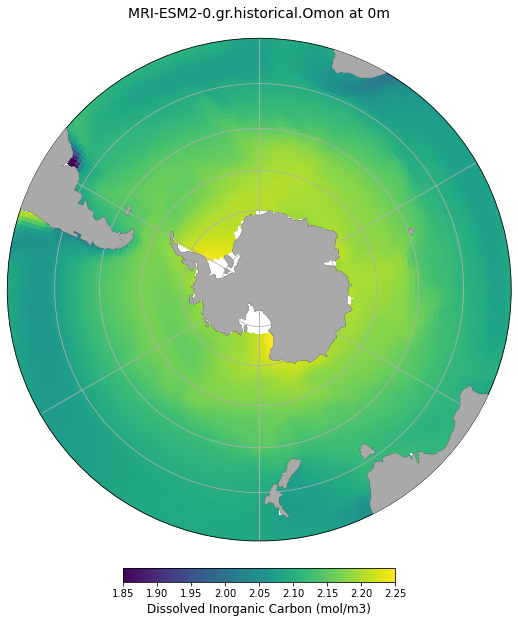

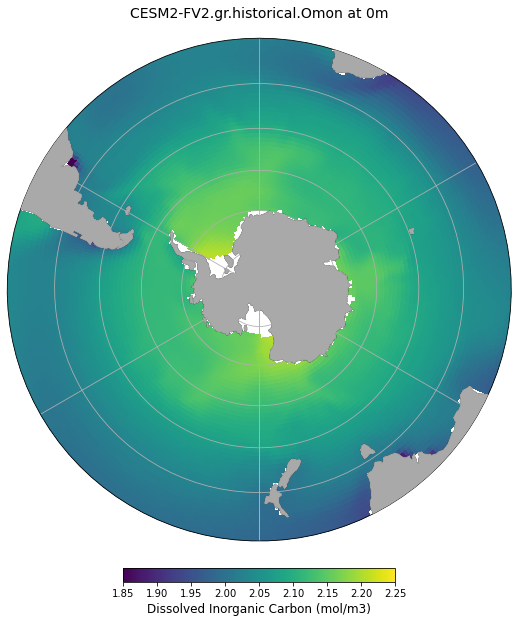

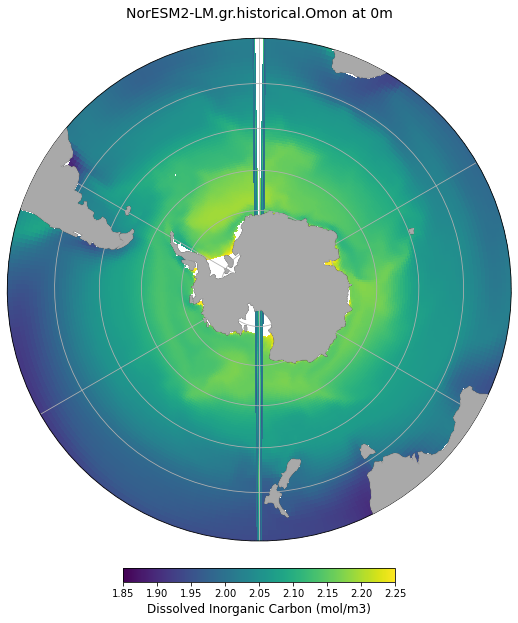

In [15]:
for name, ds_DIC in dd_DIC.items():
    #ax = axarr_DIC.flat[ax_idx]
    a = ds_DIC.dissic.isel(lev = 0)

    surf = a.isel(time = slice(0, 239)).mean('time', keep_attrs=True)

    lat = surf.lat.transpose('y','x')
#     print(lat)
    lon = surf.lon.transpose('y','x')
    draw_SOcustom(lon.data,lat.values,surf,cmap='viridis',cbar_label='Dissolved Inorganic Carbon (mol/m3)',
                  title=name+' at 0m',plot_type='pcolormesh',clims=[1.85,2.25])
    plt.savefig(name+'DIC_10m_stereoproj_20yr.png')
    

#### 10m

/srv/conda/envs/notebook/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1702: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


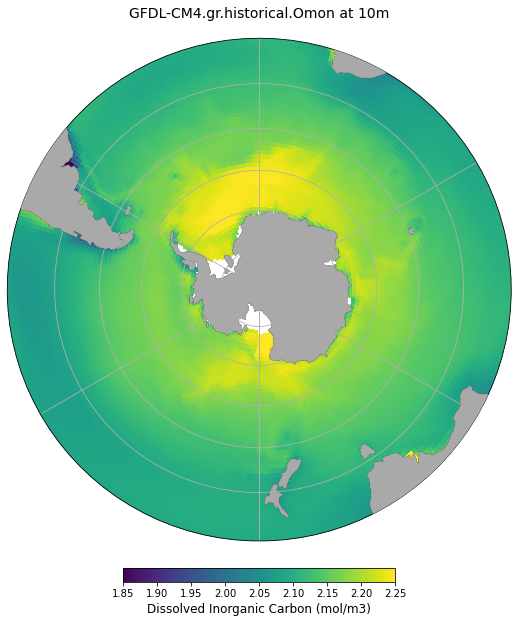

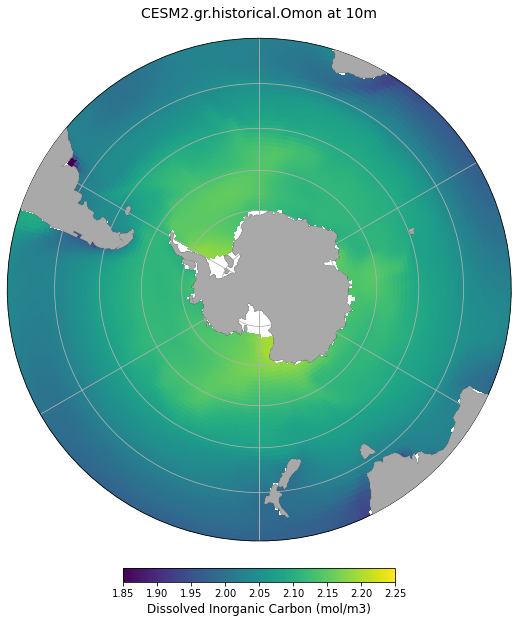

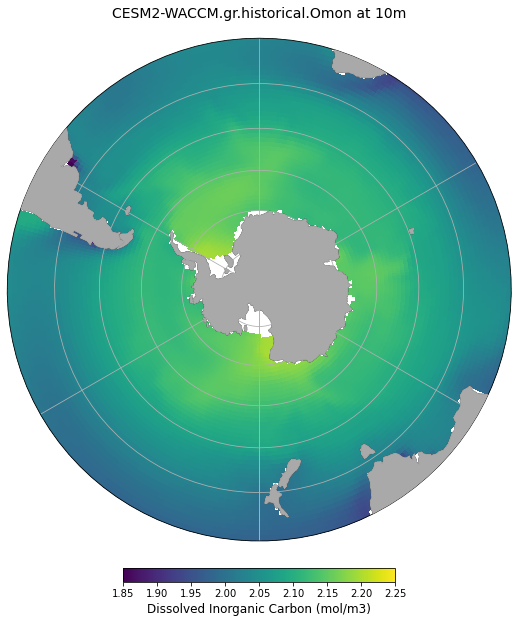

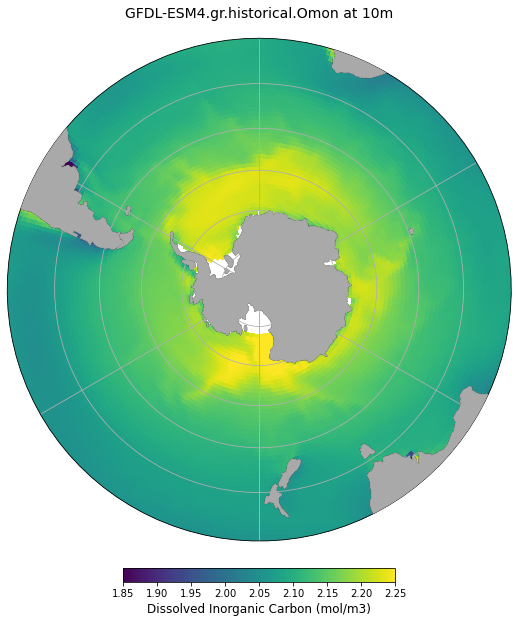

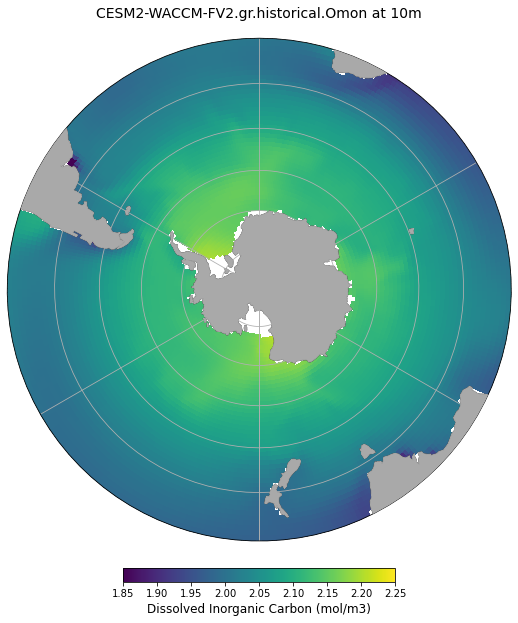

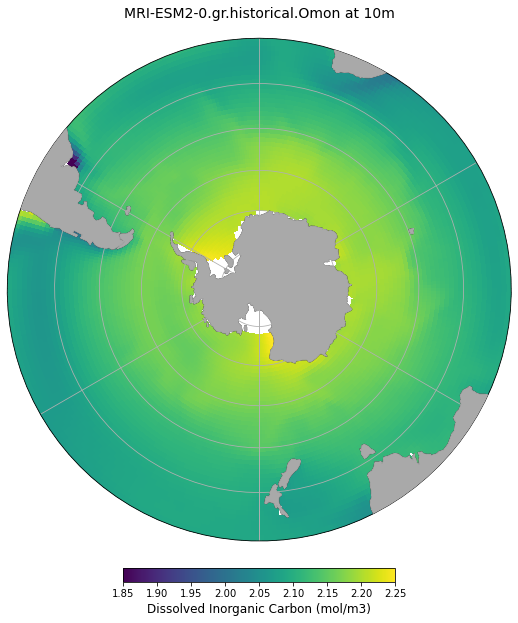

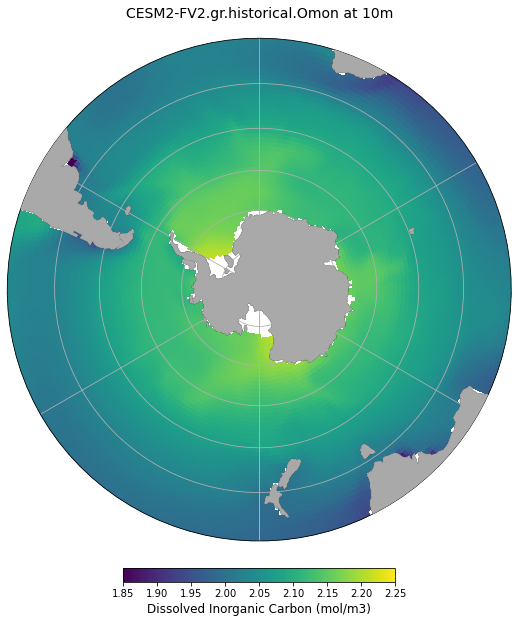

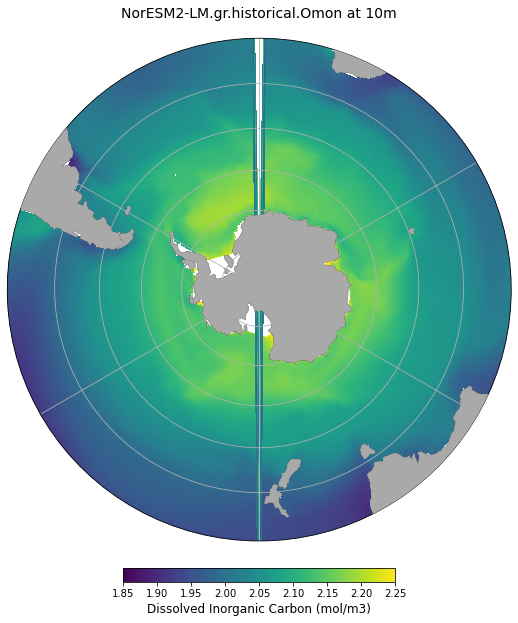

In [16]:
for name, ds_DIC in dd_DIC.items():
    #ax = axarr_DIC.flat[ax_idx]
    a = ds_DIC.dissic.isel(lev = 1)

    surf = a.isel(time = slice(0, 239)).mean('time', keep_attrs=True)

    lat = surf.lat.transpose('y','x')
#     print(lat)
    lon = surf.lon.transpose('y','x')
    draw_SOcustom(lon.data,lat.values,surf,cmap='viridis',cbar_label='Dissolved Inorganic Carbon (mol/m3)',
                  title=name+' at 10m',plot_type='pcolormesh',clims=[1.85,2.25])
    plt.savefig(name+'DIC_10m_stereoproj_20yr.png')

#### 100m

/srv/conda/envs/notebook/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1702: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


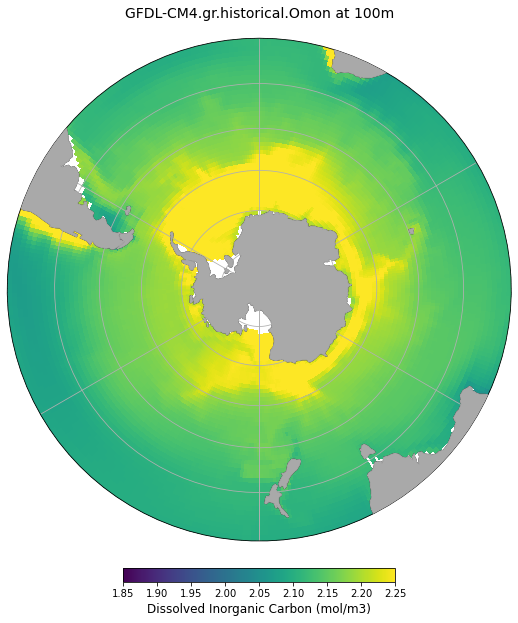

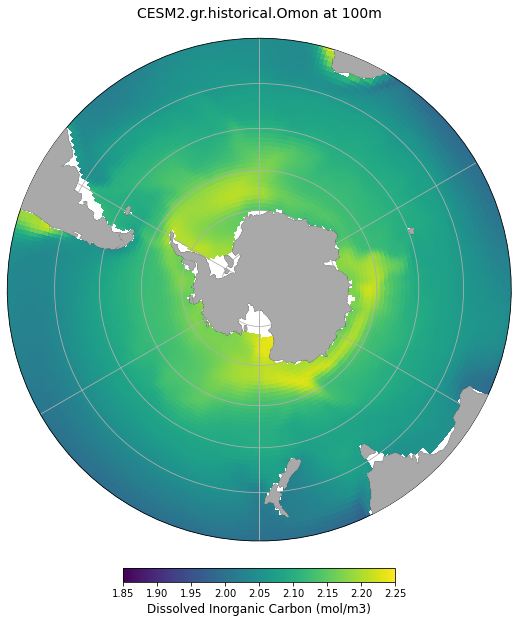

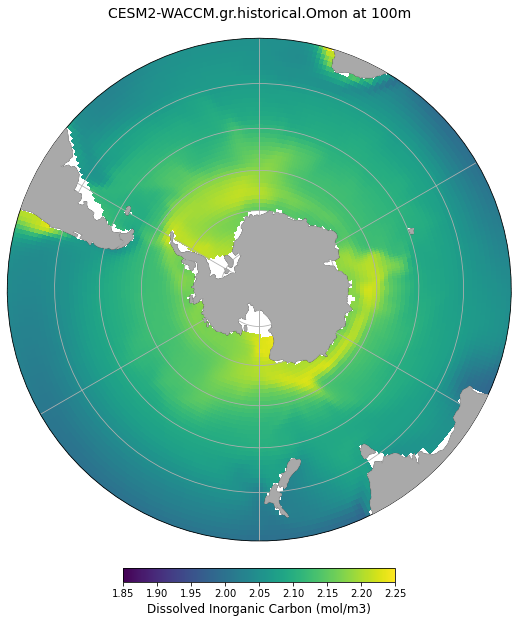

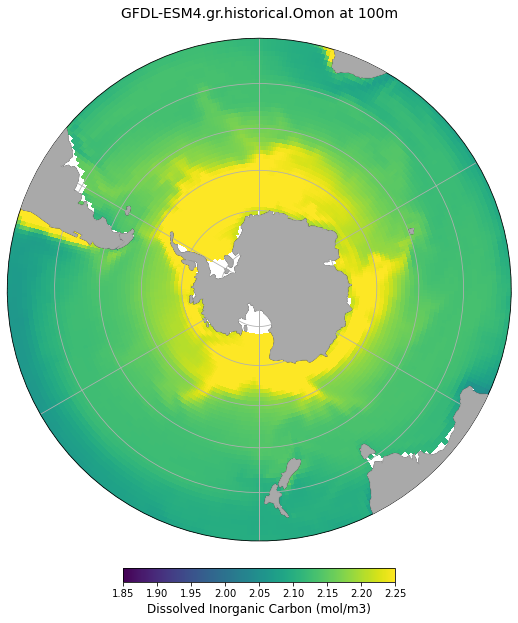

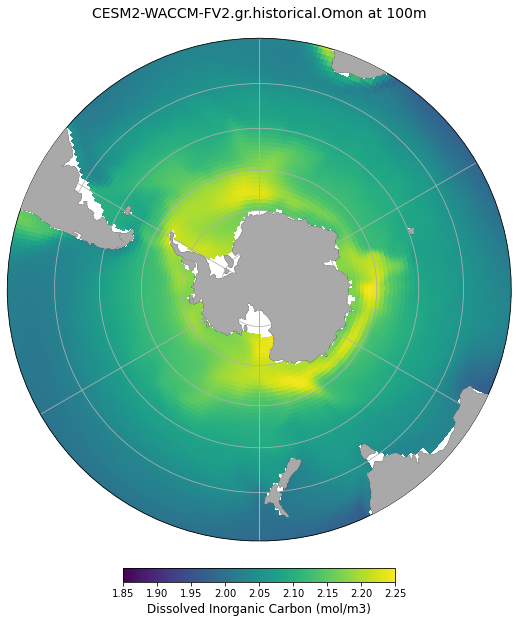

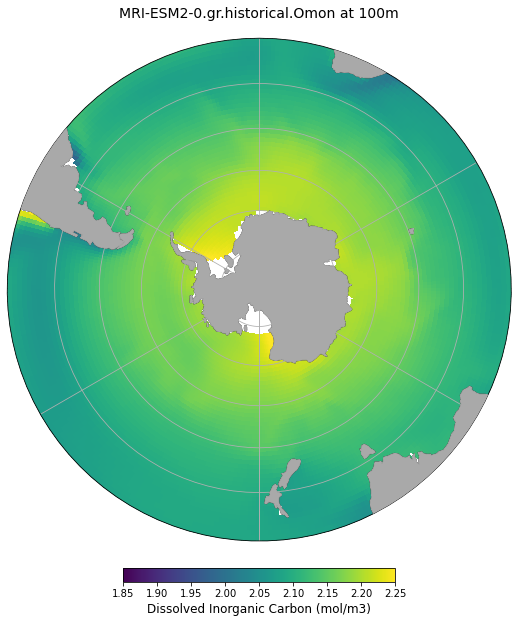

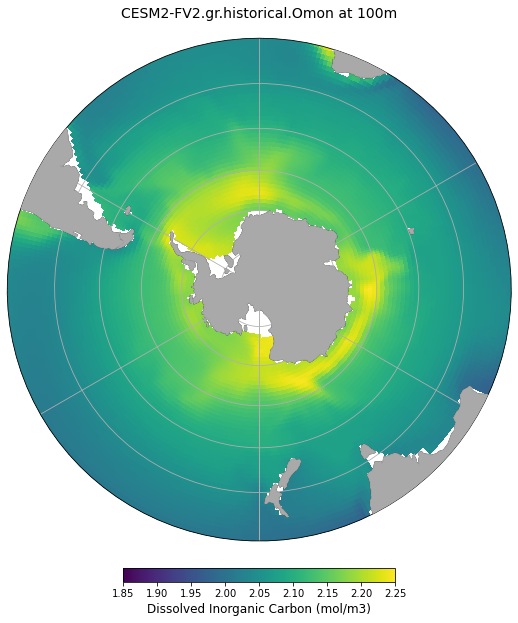

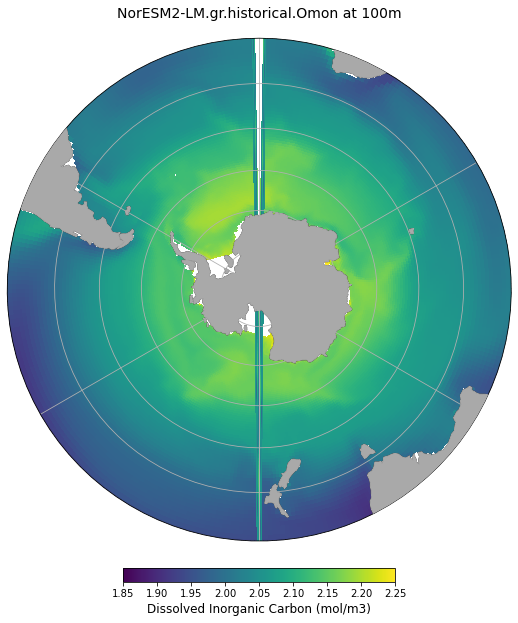

In [17]:
for name, ds_DIC in dd_DIC.items():
    #ax = axarr_DIC.flat[ax_idx]
    a = ds_DIC.dissic.isel(lev = 6)

    surf = a.isel(time = slice(0, 239)).mean('time', keep_attrs=True)

    lat = surf.lat.transpose('y','x')
#     print(lat)
    lon = surf.lon.transpose('y','x')
    draw_SOcustom(lon.data,lat.values,surf,cmap='viridis',cbar_label='Dissolved Inorganic Carbon (mol/m3)',
                  title=name+' at 100m',plot_type='pcolormesh',clims=[1.85,2.25])
    plt.savefig(name+'DIC_100m_stereoproj_20yr.png')
    

#### 200m

/srv/conda/envs/notebook/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1702: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


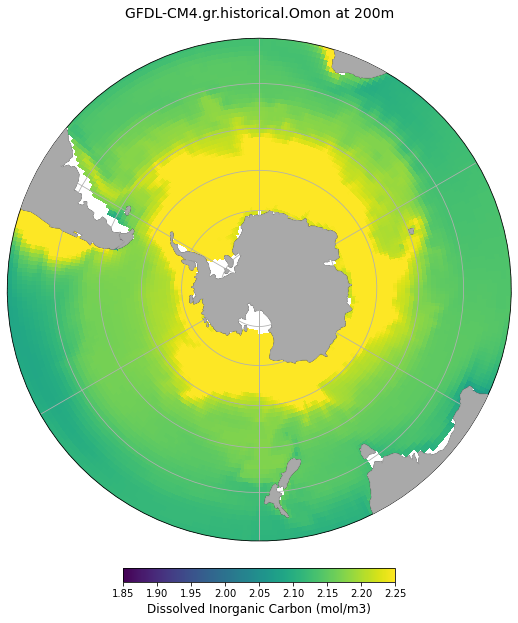

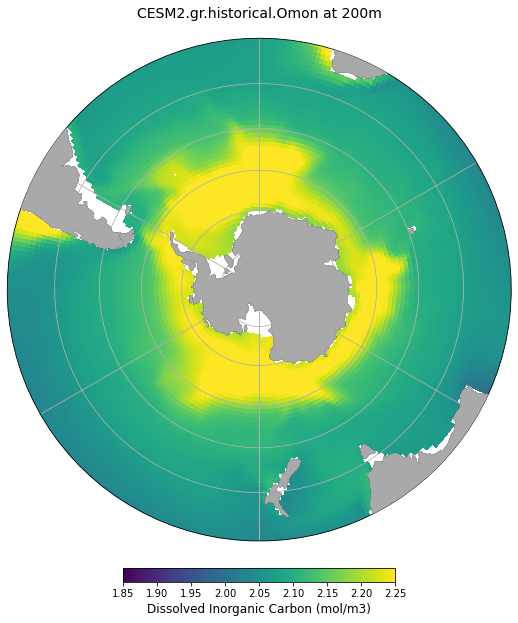

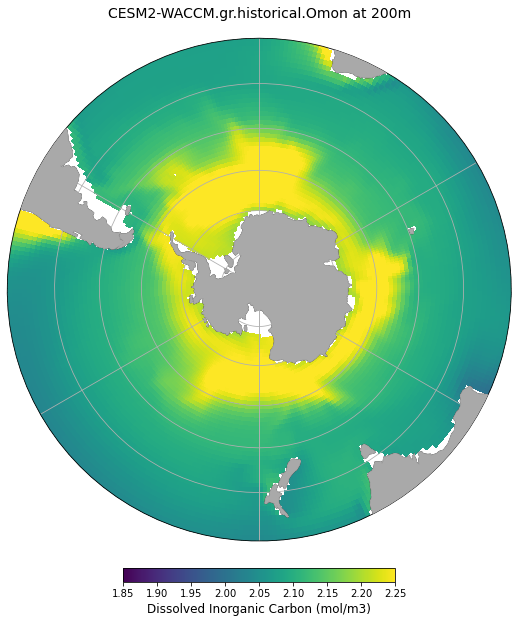

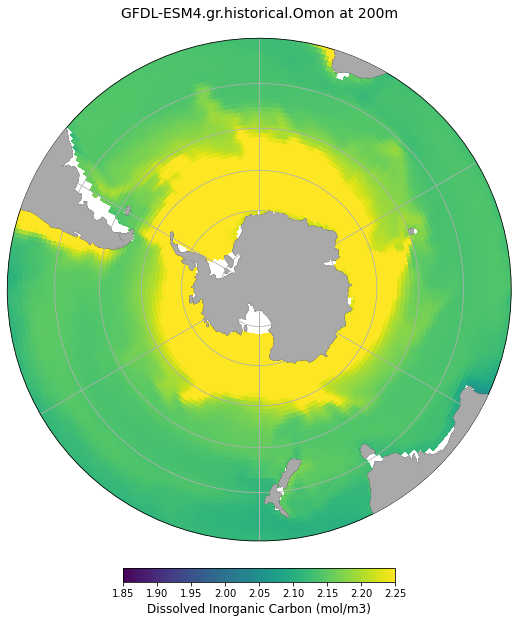

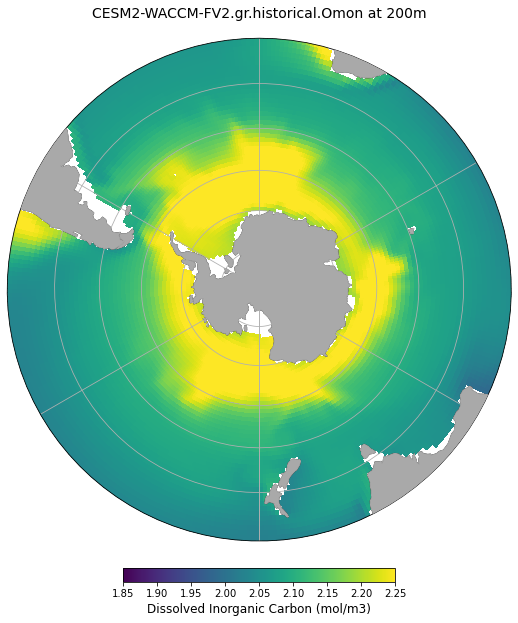

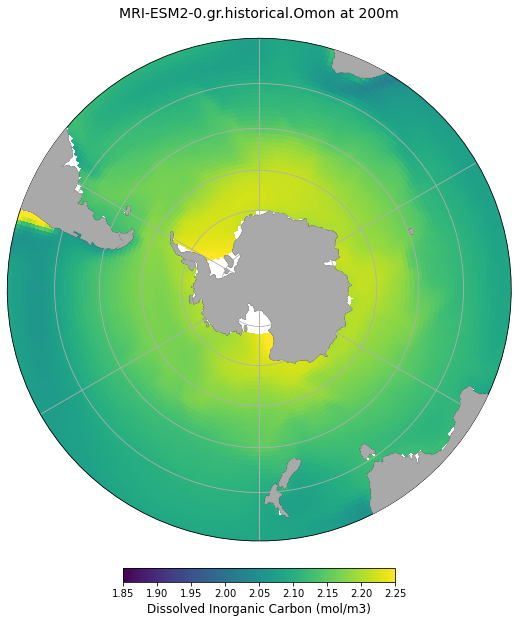

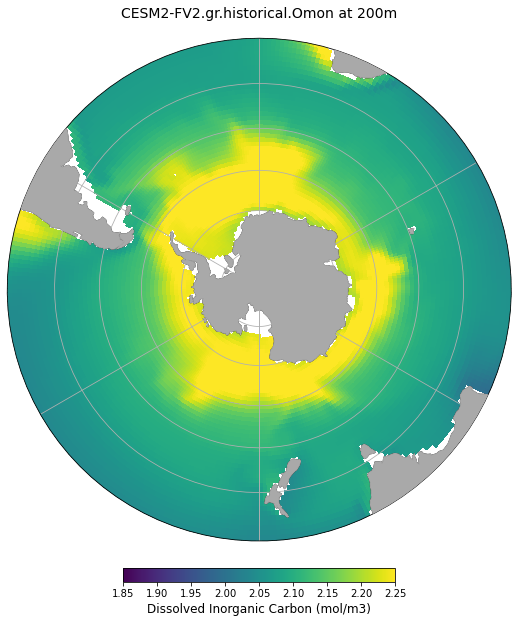

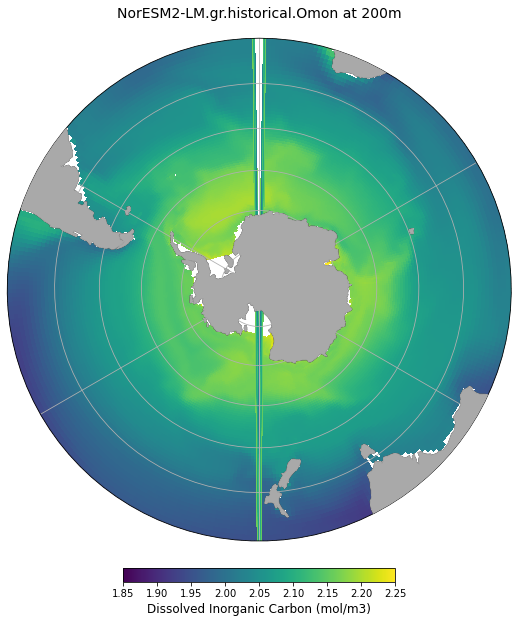

In [18]:
for name, ds_DIC in dd_DIC.items():
    #ax = axarr_DIC.flat[ax_idx]
    a = ds_DIC.dissic.isel(lev = 9)

    surf = a.isel(time = slice(0, 239)).mean('time', keep_attrs=True)

    lat = surf.lat.transpose('y','x')
#     print(lat)
    lon = surf.lon.transpose('y','x')
    draw_SOcustom(lon.data,lat.values,surf,cmap='viridis',cbar_label='Dissolved Inorganic Carbon (mol/m3)',
                  title=name+' at 200m',plot_type='pcolormesh',clims=[1.85,2.25])
    plt.savefig(name+'DIC_200m_stereoproj_20yr.png')
    

# Potential Temperature

#### 0m

#### 10m

#### 100m

#### 200m

# Salinity

#### 0m

#### 10m

#### 100m

#### 200m

# Total Alkalinity

#### 0m

#### 10m

#### 100m

#### 200m